In [3]:
!pip install pandas
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install numpy

In [4]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# df = pd.read_excel('IDD_To_Train.xlsx')
df = pd.read_csv('IDDROI_AggregatedData_T0-R0.csv')

In [7]:
df

,DateModified,Country,Utilization_Tests,Adobe_Unique Visitors,Adobe_Engaged Visits,SearchTrend_Value,Email_Opens,Sales_Calls,Utilization_MemberCount
0,4/18/21,Norway,25278,36,23,1572160,0,1,2
1,3/7/21,Norway,101058,80,72,3523807,0,13,2
2,11/29/20,Portugal,9644,747,262,12032116,0,84,2
3,12/27/20,Portugal,4514,820,246,8463269,0,104,2
4,1/10/21,Portugal,8666,736,254,6933762,0,112,2
...,...,...,...,...,...,...,...,...,...
971,9/20/20,Italy,371764,4284,2117,44137133,5840,436,171
972,11/15/20,Italy,290172,4440,2106,35067860,11887,345,172
973,12/1/19,Italy,380540,1265,307,42927896,2314,302,173
974,10/18/20,Italy,341858,4310,2076,42323278,15107,358,173


In [61]:
#Model some type of nonlinearity
df['drdr'] = df['Utilization_MemberCount']*df['Utilization_MemberCount']
df['log2dr'] = np.log2(df['Utilization_MemberCount'])

In [70]:
#Scale SearchTrend_Value
df['SearchTrend_Modified'] = df['SearchTrend_Value']/1000

In [71]:
#Fix any place where the log2 is -infinity (log of 0)
df.loc[df['log2dr']==-np.inf,'log2dr'] = 0

In [72]:
# train = df[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Revenue','Calls','Tenure']]
# X = train[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Calls','Tenure']]
# X_ols = train[['AffectedPop','UV','NumReps','Staffed']]
train = df[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']]
X = train[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
X_ols = train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
y = train['Utilization_Tests']

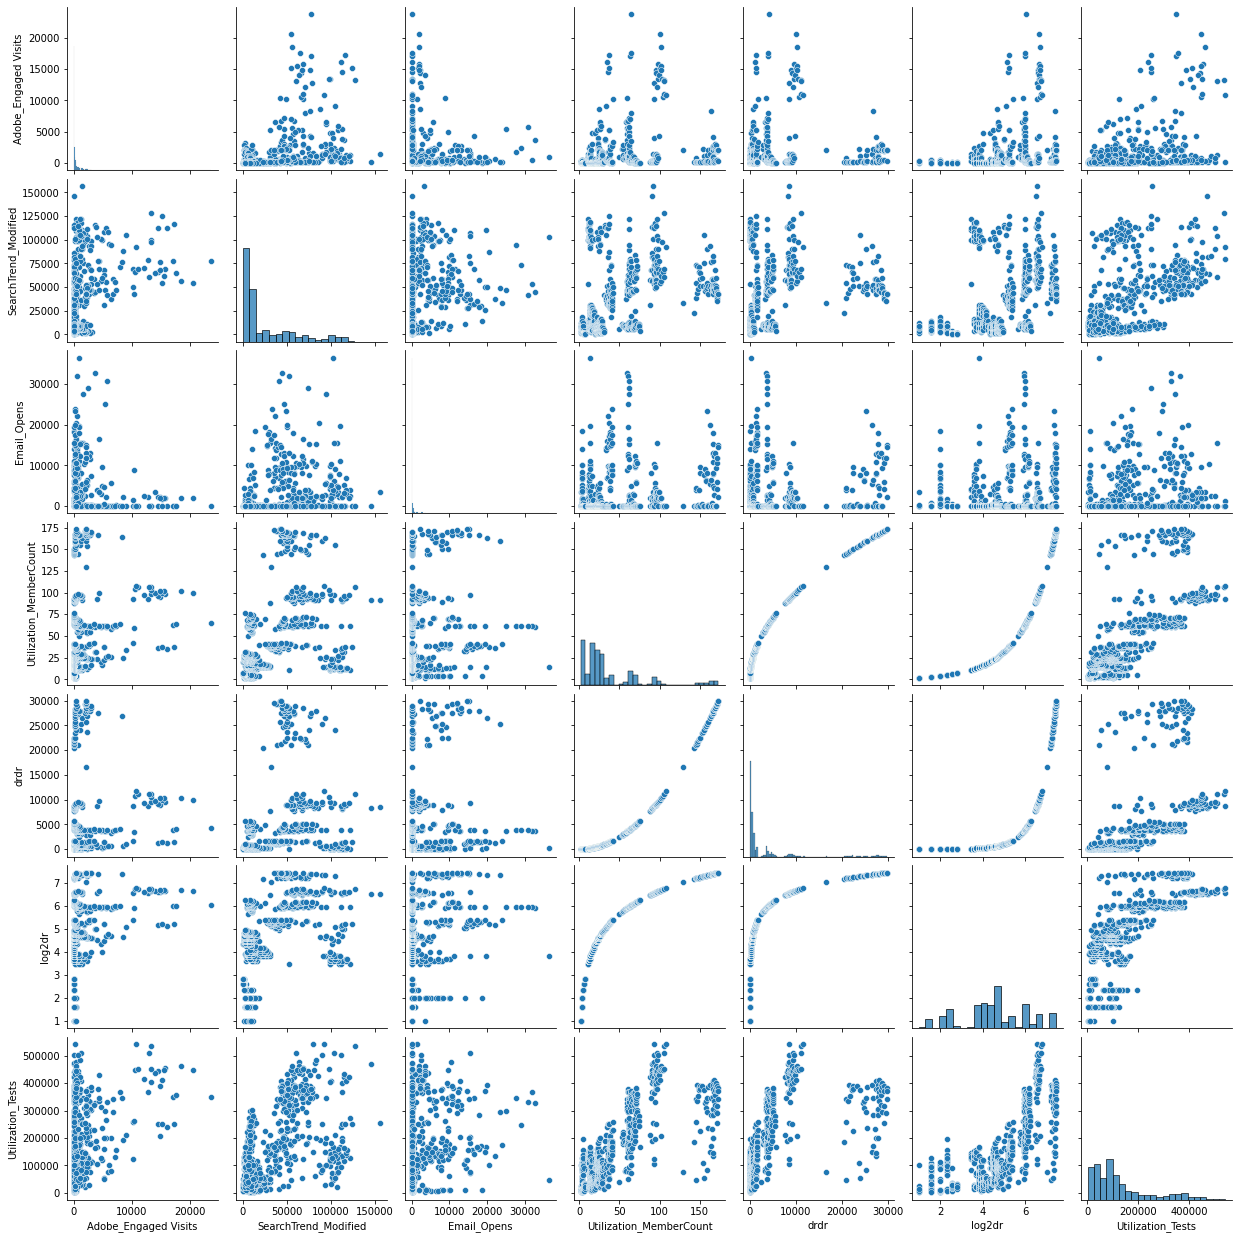

In [73]:
#Look at interactions between the variables. Not very many great relationships except definitely some interactions between # of Drs and Revenue
sns.pairplot(train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']])
plt.show()

In [74]:
!pip install sklearn

In [75]:
#Split the data into train/test datasets and get ready to build a random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor()
X = pd.get_dummies(X)

x_train, x_test, y_train, y_test = train_test_split(X,y)

In [76]:
#Train an OLS regression on the original dataset (NOT INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_orig)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols[:-2]])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.716
Model:                            GLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     366.2
Date:                Tue, 27 Apr 2021   Prob (F-statistic):          1.01e-195
Time:                        17:17:31   Log-Likelihood:                -9138.6
No. Observations:                 732   AIC:                         1.829e+04
Df Residuals:                     726   BIC:                         1.832e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

In [77]:
#Train an OLS regression on the modified dataset (INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_all)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.813
Model:                            GLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     449.4
Date:                Tue, 27 Apr 2021   Prob (F-statistic):          1.39e-258
Time:                        17:17:31   Log-Likelihood:                -8985.9
No. Observations:                 732   AIC:                         1.799e+04
Df Residuals:                     724   BIC:                         1.802e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    8

In [78]:
#Fit the random forest and predict the values for the test dataset

rf.fit(x_train,y_train)
y_predict_rf = rf.predict(x_test)

In [79]:
#Which variables are most important for the random forest? Number of doctors is the strongest predictor
importances = pd.DataFrame(list(zip(*[x_train.columns,rf.feature_importances_])),columns=['variable','importance'])
importances.sort_values('importance',ascending=False)

,variable,importance
4,Utilization_MemberCount,2.546082e-01
6,log2dr,2.523112e-01
5,drdr,2.191580e-01
3,Sales_Calls,1.255635e-01
1,SearchTrend_Modified,3.514233e-02
...,...,...
32,DateModified_2/7/21,2.501056e-05
20,DateModified_11/29/20,2.406900e-05
15,DateModified_10/4/20,1.330959e-05
67,DateModified_9/8/19,9.578481e-06


In [80]:
#Import functions to calculate metrics from sklearn to make it easier to ensure I'm calculating it correctly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [81]:
mse_rf = mean_squared_error(y_test, y_predict_rf)
mae_rf = mean_absolute_error(y_test, y_predict_rf)
r2_rf = r2_score(y_test, y_predict_rf)
mse_ols = mean_squared_error(y_test, y_predict_ols)
mae_ols = mean_absolute_error(y_test, y_predict_ols)
r2_ols = r2_score(y_test, y_predict_ols)

print(f'OLS\nMSE: {mse_ols:0,.0f}\t\tMAE: {mae_ols:0,.1f}\t\tR-Squared: {r2_ols:0.3f}')
print()
print(f'Random Forest\nMSE: {mse_rf:0,.0f}\t\tMAE: {mae_rf:0,.1f}\t\tR-Squared: {r2_rf:0.3f}')

OLS
MSE: 3,404,835,232		MAE: 40,496.5		R-Squared: 0.764

Random Forest
MSE: 1,305,847,261		MAE: 20,739.0		R-Squared: 0.909


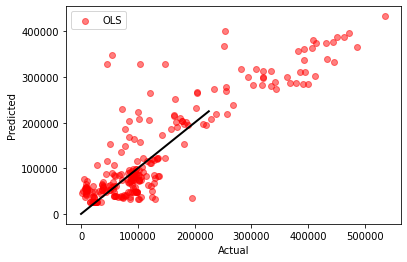

In [82]:
#How closely to the y=x line do the OLS predictions run?
plt.scatter(y_test, y_predict_ols, alpha=0.5, c='r', label='OLS')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

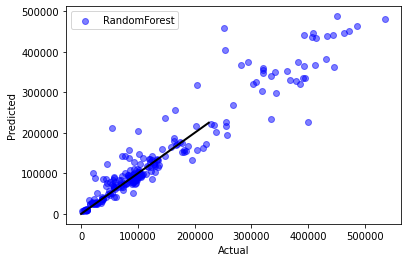

In [83]:
#How closely to the y=x line do the random forest predictions run?
plt.scatter(y_test, y_predict_rf, alpha=0.5, c='b', label='RandomForest')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()